In [1]:
import h5py
import numpy as np
from synthesizer.conversions import lnu_to_absolute_mag
import pandas as pd
import unyt
from unyt import erg, Hz, s
import cmasher as cmr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import glob

sys.path.append("/home/jovyan/camels/proj1/")
from setup_params import get_photometry, get_luminosity_function, get_colour_distribution, get_safe_name, get_colour_dir_name, get_magnitude_mask
from variables_config import get_config

In [2]:
def process_data(input_dir, redshift_values, uvlf_limits, n_bins_lf, lf_data_dir, 
                colour_limits, n_bins_colour, colour_data_dir, category, bands, 
                colour_pairs=None, mag_limits=None, simulation=None, dataset="CV"):
    """Process data for any combination of bands and color pairs"""
    # Handle SIMBA/Simba case
    sim_prefix = "Simba" if simulation == "SIMBA" else simulation
    
    photo_files = [f for f in os.listdir(input_dir) if f.endswith('_photometry.hdf5')]
    
    for filename in photo_files:
        sim_name = filename.replace(f'{sim_prefix}_', '').replace('_photometry.hdf5', '')
        ##print(f"\nProcessing {sim_name}")
        
        for snap, redshift_info in redshift_values.items():
            ##print(f"  Processing z={redshift_info['label']}")
            
            try:
                spec_type = "intrinsic" if category == "intrinsic" else "attenuated"
                
                # Process filters
                if bands is not None:
                    filters_to_process = [bands] if isinstance(bands, str) else bands
                    
                    photo = get_photometry(
                        sim_name=sim_name,
                        spec_type=spec_type,
                        snap=snap,
                        sps="BC03",
                        model=sim_prefix,
                        filters=filters_to_process,
                        photo_dir=input_dir
                    )
                    
                    # Process UVLFs
                    for band in filters_to_process:
                        # Create UVLF data
                        phi, phi_sigma, hist, bin_lims = get_luminosity_function(
                            photo, band, *uvlf_limits, n_bins=n_bins_lf
                        )
                        
                        bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
                        uvlf_df = pd.DataFrame({
                            'magnitude': bin_centers,
                            'phi': phi,
                            'phi_sigma': phi_sigma,
                            'hist': hist
                        })
                        
                        # Setup directory and ensure it exists
                        filter_system = get_safe_name(band, filter_system_only=True)
                        output_dir = os.path.join(lf_data_dir[category][filter_system], 
                                                get_safe_name(redshift_info['label']))
                        os.makedirs(output_dir, exist_ok=True)
                        ##print(f"Created directory: {output_dir}")
                        
                        # Save UVLF data
                        uvlf_filename = f"UVLF_{sim_name}_{get_safe_name(band)}_{get_safe_name(redshift_info['label'])}_{spec_type}.txt"
                        output_path = os.path.join(output_dir, uvlf_filename)
                        uvlf_df.to_csv(output_path, index=False, sep='\t')
                        ##print(f"Saved UVLF data to: {output_path}")
                
                # Process colours
                if colour_pairs:
                    for band1, band2 in colour_pairs:
                        if band1 in photo and band2 in photo:
                            # Create color data
                            mask = get_magnitude_mask(photo, [band1, band2], mag_limits)
                            colour_dist, bin_lims = get_colour_distribution(
                                photo, band1, band2, *colour_limits,
                                n_bins=n_bins_colour, mask=mask
                            )
                            
                            bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
                            colour_df = pd.DataFrame({
                                'colour': bin_centers,
                                'distribution': colour_dist
                            })
                            
                            # Setup directory and ensure it exists
                            filter_system = get_colour_dir_name(band1, band2)
                            output_dir = os.path.join(colour_data_dir[category],
                                                    filter_system,
                                                    get_safe_name(redshift_info['label']))
                            os.makedirs(output_dir, exist_ok=True)
                            ##print(f"Created directory: {output_dir}")
                            
                            # Save color data
                            colour_filename = f"Colour_{sim_name}_{filter_system}_{get_safe_name(redshift_info['label'])}_{spec_type}.txt"
                            output_path = os.path.join(output_dir, colour_filename)
                            print(f"DEBUG: Saving color file as: {output_path}")
                            colour_df.to_csv(output_path, index=False, sep='\t')
                            ##print(f"Saved color data to: {output_path}")
                
                ##print(f"    Completed processing for z={redshift_info['label']}")
                
            except Exception as e:
                ##print(f"Error processing {sim_name} at z={redshift_info['label']}: {str(e)}")
                continue

In [3]:
def process_all_data(input_dir, redshift_values, uvlf_limits, n_bins_lf, lf_data_dir, 
                    colour_limits, n_bins_colour, colour_data_dir, mag_limits, 
                    simulation=None, dataset="CV"):
    """Process all combinations of data types and bands"""
    
    config = get_config(dataset=dataset, simulation=simulation)
    band_combinations = config["filters"]
    colour_combinations = config["colour_pairs"]

    # Process each category
    for category in ["attenuated", "intrinsic"]:
        # Process each band combination
        ##print(f"\nProcessing {category} bands: {band_combinations[category]}")
        process_data(
            input_dir=input_dir,
            redshift_values=redshift_values,
            uvlf_limits=uvlf_limits,
            n_bins_lf=n_bins_lf,
            lf_data_dir=lf_data_dir,
            colour_limits=colour_limits,
            n_bins_colour=n_bins_colour,
            colour_data_dir=colour_data_dir,
            category=category,
            bands=band_combinations[category],
            colour_pairs=None,
            mag_limits=mag_limits,
            simulation=simulation,
            dataset=dataset
        )

        # Process colour pairs
        if colour_combinations:
            ##print(f"\nProcessing {category} colours: {colour_combinations}")
            process_data(
                input_dir=input_dir,
                redshift_values=redshift_values,
                uvlf_limits=uvlf_limits,
                n_bins_lf=n_bins_lf,
                lf_data_dir=lf_data_dir,
                colour_limits=colour_limits,

                n_bins_colour=n_bins_colour,
                colour_data_dir=colour_data_dir,
                category=category,
                bands=None,
                colour_pairs=colour_combinations,
                mag_limits=mag_limits,
                simulation=simulation,
                dataset=dataset
            )



if __name__ == "__main__":
    simulations_to_run = ["IllustrisTNG"]#, "SIMBA", "Astrid"]
    datasets = ["CV"]#, "1P"]
    
    for simulation in simulations_to_run:
        for dataset in datasets:
            ##print(f"\nProcessing {simulation} - {dataset} dataset")
            config = get_config(dataset=dataset, simulation=simulation)
            
            process_all_data(
                input_dir=config["input_dir"],
                redshift_values=config["redshift_values"],
                uvlf_limits=config["uvlf_limits"],
                n_bins_lf=config["n_bins_lf"],
                lf_data_dir=config["lf_data_dir"],
                colour_limits=config["colour_limits"],
                n_bins_colour=config["n_bins_colour"],
                colour_data_dir=config["colour_data_dir"],
                mag_limits=config["mag_limits"],
                simulation=simulation,
                dataset=dataset
            )

In [4]:
def get_simulation_color(simulation):
    """Get standard color for each simulation"""
    color_map = {
        "IllustrisTNG": "blue",
        "SIMBA": "green",
        "Astrid": "red",
        "Swift-EAGLE": "orange"
    }
    color = color_map.get(simulation, "gray")
    #print(f"Assigning color {color} to simulation {simulation}")
    return color

In [5]:
def plot_cv_uvlf(input_dir, redshift_label, band, category, simulation):
    """Plot UVLF for CV simulations showing mean, scatter, and individual runs."""
    # Get all relevant files
    pattern = f"UVLF_CV_*_{get_safe_name(band)}_{redshift_label}_{category}.txt"
    files = glob.glob(os.path.join(input_dir, pattern))
    
    if not files:
        #print(f"No files found matching pattern: {pattern}")
        return None, None, None
    
    # Read all data
    all_data = []
    for f in files:
        try:
            df = pd.read_csv(f, sep='\t')
            all_data.append(df)
        except Exception as e:
            #print(f"Error reading {f}: {e}")
            continue
    
    if not all_data:
        #print("No valid data found")
        return None, None, None
    
    # Convert to arrays
    magnitudes = all_data[0]['magnitude'].values
    phi_arrays = np.array([df['phi'].values for df in all_data])
    phi_sigma_arrays = np.array([df['phi_sigma'].values for df in all_data])
    
    # Calculate statistics
    mean_phi = np.mean(phi_arrays, axis=0)
    std_phi = np.std(phi_arrays, axis=0)
    lower_percentile = np.percentile(phi_arrays, 16, axis=0)
    upper_percentile = np.percentile(phi_arrays, 84, axis=0)
    
    # Get simulation color
    sim_color = get_simulation_color(simulation)
    #print(f"Using color {sim_color} for {simulation}")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot individual simulations with simulation-specific color
    for phi in phi_arrays:
        ax.plot(magnitudes, phi, '-', color=sim_color, alpha=0.1)
    
    # Plot mean and percentiles with simulation-specific color
    ax.plot(magnitudes, mean_phi, '-', color=sim_color, linewidth=2, 
            label=f'{simulation} Mean UVLF')
    ax.fill_between(magnitudes, lower_percentile, upper_percentile,
                   alpha=0.3, color=sim_color, label='16th-84th Percentile')
    
    # Add error bars
    ax.errorbar(magnitudes, mean_phi, yerr=std_phi/np.sqrt(len(all_data)),
               fmt='none', ecolor=sim_color, capsize=5)
    
    # Customize plot
    ax.set_xlabel('M$_{UV}$ [AB mag]', fontsize=12)
    ax.set_ylabel('log$_{10}$ φ [Mpc$^{-3}$ mag$^{-1}$]', fontsize=12)
    ax.set_title(f'{simulation} {band} UVLF\n{category}, {redshift_label}', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    return fig, magnitudes, mean_phi  # Return the figure and data


In [6]:


def plot_cv_colors(input_dir, redshift_label, band1, band2, category, simulation):
    """Plot color distributions for CV simulations."""
    filter_system = get_colour_dir_name(band1, band2)
    pattern = f"Colour_CV_*_{filter_system}_{redshift_label}_{category}.txt"
    
    print(f"DEBUG: Looking for color files in: {input_dir}")
    print(f"DEBUG: Using pattern: {pattern}")
    files = glob.glob(os.path.join(input_dir, pattern))
    print(f"DEBUG: Found files: {files}")

    filter_system = get_colour_dir_name(band1, band2)
    pattern = f"Colour_CV_*_{filter_system}_{redshift_label}_{category}.txt"
    files = glob.glob(os.path.join(input_dir, pattern))
    
    if not files:
        #print(f"No files found matching pattern: {pattern}")
        return None
    
    # Read all data
    all_data = []
    for f in files:
        try:
            df = pd.read_csv(f, sep='\t')
            all_data.append(df)
        except Exception as e:
            #print(f"Error reading {f}: {e}")
            continue
    
    if not all_data:
        #print("No valid data found")
        return None
    
    # Convert to arrays
    colors = all_data[0]['colour'].values
    dist_arrays = np.array([df['distribution'].values for df in all_data])
    
    # Calculate statistics
    mean_dist = np.mean(dist_arrays, axis=0)
    std_dist = np.std(dist_arrays, axis=0)
    lower_percentile = np.percentile(dist_arrays, 16, axis=0)
    upper_percentile = np.percentile(dist_arrays, 84, axis=0)
    
    # Get simulation color
    sim_color = get_simulation_color(simulation)
    #print(f"Using color {sim_color} for color distribution of {simulation}")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot individual distributions
    n_sims_to_plot = min(5, len(dist_arrays))
    random_indices = np.random.choice(len(dist_arrays), size=n_sims_to_plot, replace=False)
    for idx in random_indices:
        ax.plot(colors, dist_arrays[idx], '-', alpha=0.3, color=sim_color)
    
    # Plot mean and percentiles
    ax.plot(colors, mean_dist, '-', color=sim_color, linewidth=2, 
            label=f'{simulation} Mean Distribution')
    ax.fill_between(colors, lower_percentile, upper_percentile,
                   alpha=0.3, color=sim_color, label='16th-84th Percentile')
    
    # Customize plot
    ax.set_xlabel(f'{band1} - {band2} [mag]', fontsize=12)
    ax.set_ylabel('Normalized Count', fontsize=12)
    ax.set_title(f'{simulation} Color Distribution\n{category}, {redshift_label}', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    return fig

In [7]:

def plot_combined_uvlf(all_sims_data, redshifts, output_dir):
    """
    Create a multi-panel plot showing UVLFs for all simulations at different redshifts.
    
    Parameters:
    -----------
    all_sims_data : dict
        Dictionary with simulation names as keys, containing UVLF data
    redshifts : list
        List of redshift values to plot
    output_dir : str
        Directory to save the plot
    """
    num_redshifts = len(redshifts)
    fig, axes = plt.subplots(1, num_redshifts, figsize=(4*num_redshifts, 4))
    if num_redshifts == 1:
        axes = [axes]
    
    # Plot for each redshift
    for ax, z in zip(axes, redshifts):
        for sim_name, sim_data in all_sims_data.items():
            color = get_simulation_color(sim_name)
            
            # Get data for this redshift
            z_data = sim_data[z]
            
            # Plot intrinsic (dashed)
            if 'intrinsic' in z_data:
                ax.plot(z_data['intrinsic']['magnitude'], 
                       z_data['intrinsic']['phi'],
                       '--', color=color, alpha=0.5, label=f'{sim_name} (intrinsic)')
            
            # Plot attenuated (solid)
            if 'attenuated' in z_data:
                ax.plot(z_data['attenuated']['magnitude'], 
                       z_data['attenuated']['phi'],
                       '-', color=color, label=f'{sim_name} (attenuated)')
        
        # Customize each panel
        ax.set_xlabel('M$_{AB}$')
        ax.set_ylabel('$\phi$ [Mpc$^{-3}$ dex$^{-1}$]')
        ax.set_ylim(-5.0, -2.0)
        ax.set_xlim(-27, -20)
        ax.grid(True, alpha=0.3)
        ax.text(0.05, 0.95, f'z = {z}', transform=ax.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    # Add legend to the first panel
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'combined_uvlf.pdf'), 
                bbox_inches='tight', dpi=300)
    plt.close()

In [8]:


def process_and_plot_all(simulations=["IllustrisTNG", "SIMBA", "Astrid", "Swift-EAGLE"]):
    """Process and plot data for all simulations"""
    all_data = {}
    
    # First collect all data
    for simulation in simulations:
        sim_data = {}
        config = get_config(dataset="CV", simulation=simulation)
        
        for snap, redshift_info in config["redshift_values"].items():
            z_data = {}
            
            for category in ['intrinsic', 'attenuated']:
                for band in config["filters"][category]:
                    filter_system = get_safe_name(band, filter_system_only=True)
                    data_dir = os.path.join(config["lf_data_dir"][category][filter_system],
                                          get_safe_name(redshift_info['label']))
                    
                    # Read and combine all CV runs
                    pattern = f"UVLF_CV_*_{get_safe_name(band)}_{get_safe_name(redshift_info['label'])}_{category}.txt"
                    files = glob.glob(os.path.join(data_dir, pattern))
                    
                    if files:
                        all_runs_data = []
                        for f in files:
                            df = pd.read_csv(f, sep='\t')
                            all_runs_data.append(df)
                        
                        # Calculate mean
                        mean_data = pd.concat(all_runs_data).groupby(level=0).mean()
                        z_data[category] = mean_data
            
            sim_data[redshift_info['redshift']] = z_data
        
        all_data[simulation] = sim_data
    
    # Create combined plot
    plot_combined_uvlf(all_data, 
                      sorted(config["redshift_values"].values(), 
                            key=lambda x: x['redshift']),
                      config["plots_dir"])


DEBUG: Looking for color files in: /home/jovyan/camels/proj1/CV_set/CV_outputs/colours/IllustrisTNG/intrinsic/GALEX_FUV-NUV/z2.0
DEBUG: Using pattern: Colour_CV_*_GALEX_FUV-NUV_z2.0_intrinsic.txt
DEBUG: Found files: []
DEBUG: Looking for color files in: /home/jovyan/camels/proj1/CV_set/CV_outputs/colours/IllustrisTNG/attenuated/GALEX_FUV-NUV/z2.0
DEBUG: Using pattern: Colour_CV_*_GALEX_FUV-NUV_z2.0_attenuated.txt
DEBUG: Found files: []
DEBUG: Looking for color files in: /home/jovyan/camels/proj1/CV_set/CV_outputs/colours/IllustrisTNG/intrinsic/GALEX_FUV-NUV/z1.5
DEBUG: Using pattern: Colour_CV_*_GALEX_FUV-NUV_z1.5_intrinsic.txt
DEBUG: Found files: []
DEBUG: Looking for color files in: /home/jovyan/camels/proj1/CV_set/CV_outputs/colours/IllustrisTNG/attenuated/GALEX_FUV-NUV/z1.5
DEBUG: Using pattern: Colour_CV_*_GALEX_FUV-NUV_z1.5_attenuated.txt
DEBUG: Found files: []
DEBUG: Looking for color files in: /home/jovyan/camels/proj1/CV_set/CV_outputs/colours/IllustrisTNG/intrinsic/GALEX_FUV-

TypeError: unhashable type: 'dict'

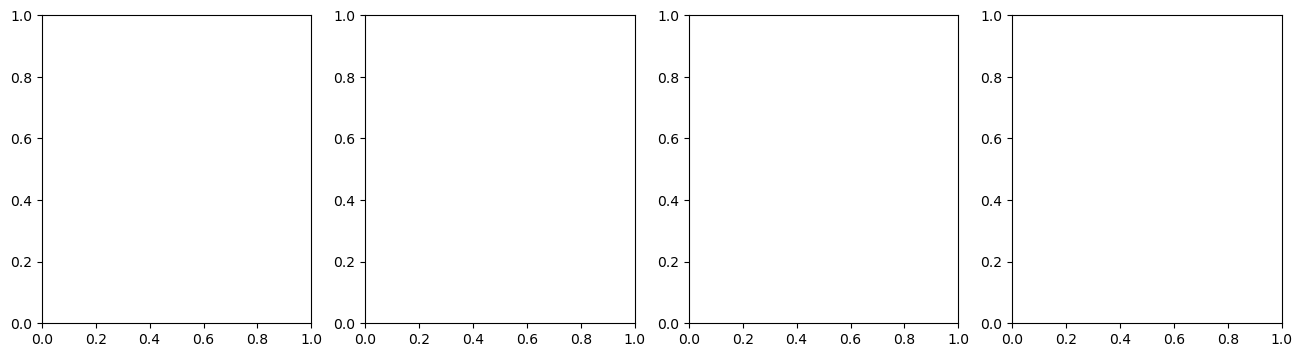

In [9]:


def process_and_plot_cv(simulation, dataset="CV"):
    """Process and plot CV set results"""
    #print(f"\nProcessing and plotting {simulation} - {dataset} dataset")
    config = get_config(dataset=dataset, simulation=simulation)
    
    # First process all the data
    process_all_data(
        input_dir=config["input_dir"],
        redshift_values=config["redshift_values"],
        uvlf_limits=config["uvlf_limits"],
        n_bins_lf=config["n_bins_lf"],
        lf_data_dir=config["lf_data_dir"],
        colour_limits=config["colour_limits"],
        n_bins_colour=config["n_bins_colour"],
        colour_data_dir=config["colour_data_dir"],
        mag_limits=config["mag_limits"],
        simulation=simulation,
        dataset=dataset
    )
    
    # Now create plots for each redshift
    plots_dir = config["plots_dir"]
    os.makedirs(plots_dir, exist_ok=True)
    
    # Collect all data for combined plot
    sim_data = {}
    
    for snap, redshift_info in config["redshift_values"].items():
        z_data = {}
        #print(f"\nPlotting for z={redshift_info['label']}")
        
        # Process UVLFs
        for category in ["intrinsic", "attenuated"]:
            for band in config["filters"][category]:
                filter_system = get_safe_name(band, filter_system_only=True)
                uvlf_dir = os.path.join(config["lf_data_dir"][category][filter_system], 
                                      get_safe_name(redshift_info['label']))
                
                # Create individual plot
                fig, magnitudes, mean_phi = plot_cv_uvlf(  # Now receiving three return values
                    input_dir=uvlf_dir,
                    redshift_label=redshift_info['label'],
                    band=band,
                    category=category,
                    simulation=simulation
                )
                
                if fig is not None:
                    plot_output_dir = os.path.join(plots_dir, simulation, "individual", "UVLFs",
                                                 category, get_safe_name(band))
                    os.makedirs(plot_output_dir, exist_ok=True)
                    
                    output_file = os.path.join(plot_output_dir,
                                             f"UVLF_{simulation}_{get_safe_name(band)}_{redshift_info['label']}_{category}.pdf")
                    fig.savefig(output_file, bbox_inches='tight', dpi=300)
                    plt.close(fig)
                    
                    # Store data for combined plot
                    if category not in z_data:
                        z_data[category] = {}
                    if magnitudes is not None and mean_phi is not None:
                        z_data[category]['magnitude'] = magnitudes
                        z_data[category]['phi'] = mean_phi
            
        sim_data[redshift_info['redshift']] = z_data

        # Process Colors
        for category in ["intrinsic", "attenuated"]:
            for band1, band2 in config["colour_pairs"]:
                filter_system = get_colour_dir_name(band1, band2)
                color_dir = os.path.join(config["colour_data_dir"][category],
                                       filter_system,
                                       get_safe_name(redshift_info['label']))
                
                fig = plot_cv_colors(
                    input_dir=color_dir,
                    redshift_label=redshift_info['label'],
                    band1=band1,
                    band2=band2,
                    category=category,
                    simulation=simulation
                )
                
                if fig is not None:
                    plot_output_dir = os.path.join(plots_dir, simulation, "individual", "colors",
                                                 category, filter_system)
                    os.makedirs(plot_output_dir, exist_ok=True)
                    
                    output_file = os.path.join(plot_output_dir,
                                             f"Color_{simulation}_{filter_system}_{redshift_info['label']}_{category}.pdf")
                    fig.savefig(output_file, bbox_inches='tight', dpi=300)
                    plt.close(fig)
    
    return sim_data  # Return data for combined plots


In [ ]:
if __name__ == "__main__":
    simulations = ["IllustrisTNG", "SIMBA", "Astrid", "Swift-EAGLE"]
    datasets = ["CV"]
    
    for simulation in simulations:
        print(f"\nProcessing {simulation}")
        for dataset in datasets:
            config = get_config(dataset=dataset, simulation=simulation)
            
            # Process all data including colors
            process_all_data(
                input_dir=config["input_dir"],
                redshift_values=config["redshift_values"],
                uvlf_limits=config["uvlf_limits"],
                n_bins_lf=config["n_bins_lf"],
                lf_data_dir=config["lf_data_dir"],
                colour_limits=config["colour_limits"],
                n_bins_colour=config["n_bins_colour"],
                colour_data_dir=config["colour_data_dir"],
                mag_limits=config["mag_limits"],
                simulation=simulation,
                dataset=dataset
            )